# Potential Plot
> - Extension following Oleg's discussion on 2020-06-28

Minimization of the following:

$$
\bar{u}_\text{pot} = \frac{U}{E_J} = -\big[ \alpha\cos(\varphi_{02}) + \cos(\varphi_{03}) + \cos(\varphi_{01}) + \\
+ \cos(\varphi_{02} - \varphi_{01} - L) + \cos(\varphi_{02} - \varphi_{03} + R)\big]
$$


In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from time import time

from functions.potential import potential_function

FLUX = float
FLUX_NUMBER = int
cos = np.cos
sin = np.sin
pi = np.pi
plt.style.use('my_official')

# Defining numeric function to mimimize the potential
Optimisation with brute forcing way through the grid - turns out to be exceedingly slow. It is better to use the analytical functions

In [2]:
from scipy import optimize
from pyprind import ProgBar

def minimise_potential_numerical(
        L: FLUX,
        R: FLUX,
        alpha: float,
        progress_bar: ProgBar,
        number_of_phi_points: int=100,
):
    phi_interval = (-pi, pi)
    
    (minimised_phi, min_potential, _, _) = optimize.brute(
        func=potential_function,
        ranges=(phi_interval, phi_interval, phi_interval),
        args = (L, R, alpha),
        full_output=True,
        Ns=number_of_phi_points,
        #finish=optimize.fmin,
        workers=16,
    )

    (phi01, phi02, phi03) = (minimised_phi[0], minimised_phi[1], minimised_phi[2])
    progress_bar.update()
    return (phi01, phi02, phi03, min_potential)

minimise_potential_numerical_vectorised = np.vectorize(
    minimise_potential_numerical,
    excluded={"alpha", "number_of_phi_points", "progress_bar"}
)

# Running the optimisation for range of L-R values

In [ ]:
start = time()

NUMBER_OF_PHI_POINTS=51
NROWSCOLS = 21
ALPHA = 1
LOWER = -0.5
UPPER = 1.5

progress_bar = ProgBar(NUMBER_OF_PHI_POINTS * NROWSCOLS, bar_char="█")
grid = np.linspace(LOWER *2*pi, UPPER * 2 * pi, NROWSCOLS)
(grid_x, grid_y) = np.meshgrid(grid, grid)
(phi01_grid, phi02_grid, phi03_grid, potential_grid) = minimise_potential_numerical_vectorised(
    L=grid_x,
    R=grid_y,
    alpha=ALPHA,
    number_of_phi_points=NUMBER_OF_PHI_POINTS,
    progress_bar=progress_bar
)

print(f"Completed in {time() - start:.2f} seconds")

0% [████████████                  ] 100% | ETA: 00:07:30

# Plot
- Usual
- With smoothing

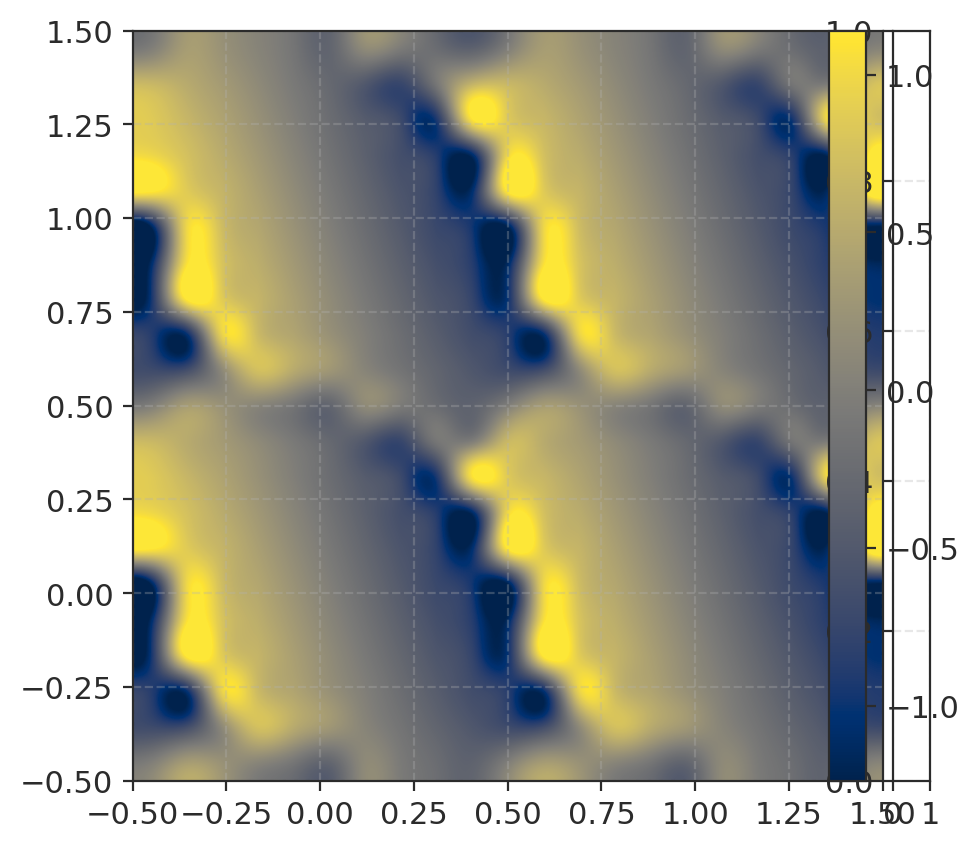

In [4]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5, 5))
divider = make_axes_locatable(ax)
cbar_axes = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(phi01_grid, 
               extent = [LOWER, UPPER, LOWER, UPPER], 
               origin= 'lower',
              cmap='cividis',
              # cmap='YlGnBu'
              interpolation='spline36')
cbar = fig.colorbar(im, ax=cbar_axes)

[Text(1, 0, '0'),
 Text(1, 0, '0.5'),
 Text(1, 0, '1'),
 Text(1, 0, '1.5'),
 Text(1, 0, '2')]

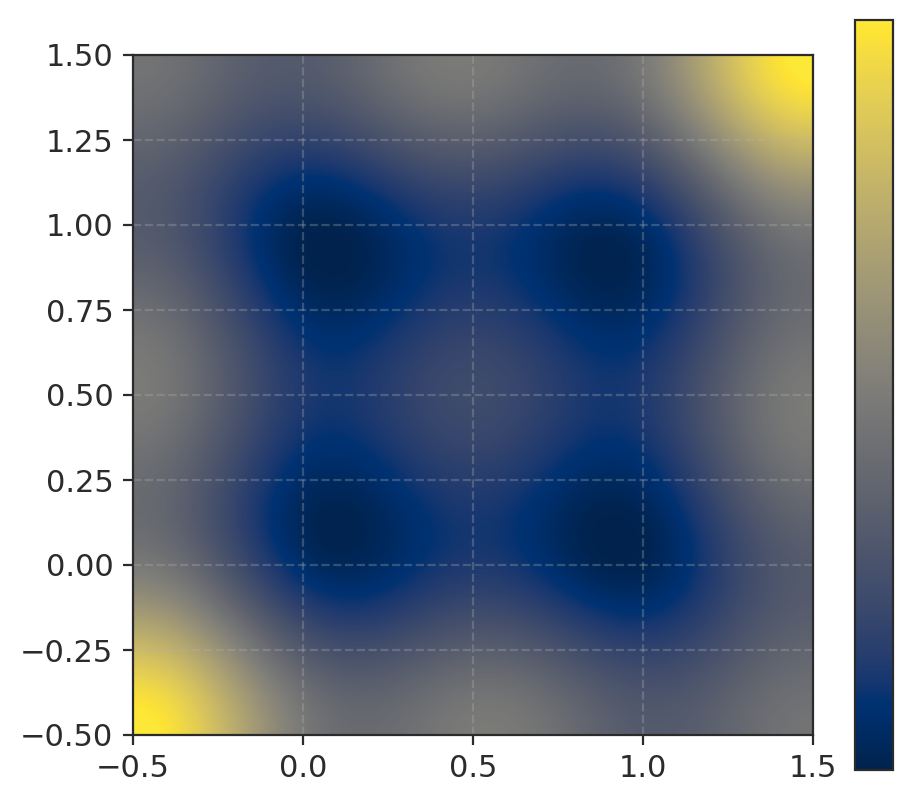

In [6]:
from scipy.ndimage.filters import gaussian_filter

fitlered_potential_grid = gaussian_filter(potential_grid, sigma=4)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5, 5))
im = ax.imshow(fitlered_potential_grid, 
               extent = [LOWER, UPPER, LOWER, UPPER], 
               origin= 'lower',
              cmap='cividis',
              # cmap='YlGnBu'
              interpolation='spline36')
cbar = fig.colorbar(im, ticks=[0, 0.5, 1, 1.5, 2])
cbar.ax.set_yticklabels([0, 0.5, 1, 1.5, 2]) 
#contour = ax.contour(grid_x, grid_y, potential_grid, 5, colors='black');
#ax.clabel(contour, inline=True, fontsize=8)

# Defining analytic functions for phi01, phi03 and potential value

$$
\varphi_{01} = \varphi_{02} - \varphi_{01} - L + 2\pi l\\
= \frac{\varphi_{02} - L}{2} + \pi l\\
\varphi_{03} = \frac{\varphi_{02} + R}{2} - \pi r
$$

and a constraints to make sure that they are minimal

$$
\cos(\varphi_{01}) + \cos(\varphi_{02} - \varphi_{01} - L) \ge 0\\
\cos(\varphi_{03}) + \cos(\varphi_{02} - \varphi_{03} + R) \ge 0
$$